In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, plot_confusion_matrix

In [3]:
df = pd.read_csv('propublica_data_for_fairml.csv')

In [4]:
df.head()

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6172 entries, 0 to 6171
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Two_yr_Recidivism     6172 non-null   int64
 1   Number_of_Priors      6172 non-null   int64
 2   score_factor          6172 non-null   int64
 3   Age_Above_FourtyFive  6172 non-null   int64
 4   Age_Below_TwentyFive  6172 non-null   int64
 5   African_American      6172 non-null   int64
 6   Asian                 6172 non-null   int64
 7   Hispanic              6172 non-null   int64
 8   Native_American       6172 non-null   int64
 9   Other                 6172 non-null   int64
 10  Female                6172 non-null   int64
 11  Misdemeanor           6172 non-null   int64
dtypes: int64(12)
memory usage: 578.8 KB


- No missing data; no rows to be dropped

In [6]:
df.isna().sum()

Two_yr_Recidivism       0
Number_of_Priors        0
score_factor            0
Age_Above_FourtyFive    0
Age_Below_TwentyFive    0
African_American        0
Asian                   0
Hispanic                0
Native_American         0
Other                   0
Female                  0
Misdemeanor             0
dtype: int64

- Balance of classes

In [7]:
df['Two_yr_Recidivism'].value_counts()

0    3363
1    2809
Name: Two_yr_Recidivism, dtype: int64

- Based on the prompt:
    - The binary variable `score_report` represents the result of the model’s prediction and another binary variable, `Two_yr_Recidivism`, indicates whether the convict actually reoffended in the subsequent two years.
- **Check the metrics of the predictions by the ML model given in the prompt:**
    - Accuracy `(TP+TN) / SampleSize`: how many correct predictions?
    - Precision `TP / (TP+FP)`: how accurate are the positive predictions?
    - Recall AKA sensitivity `TP / (TP+FN)`: model's strength in predicting positive outcome
- Precision and recall become more important when there is an imbalance in classes to be predicted. In this dataset, `Two_yr_Recidivism` is split roughly equally. Hence, there is little surprise that accuracy, precision and recall all have very similar scores.

In [8]:
print(classification_report(df['Two_yr_Recidivism'], df['score_factor']))

              precision    recall  f1-score   support

           0       0.69      0.70      0.69      3363
           1       0.63      0.62      0.62      2809

    accuracy                           0.66      6172
   macro avg       0.66      0.66      0.66      6172
weighted avg       0.66      0.66      0.66      6172



- **Racial distribution**
    - There is some inherent bias in the racial distribution of the dataset 

In [9]:
def check_if_race_is_white(African_American, Asian, Hispanic, Native_American, Other):
    if (African_American, Asian, Hispanic, Native_American, Other) == (0, 0, 0, 0, 0):
        return 1

In [10]:
race_distribution = (
    df.assign(
        White=pd.Series(
            np
            .vectorize(check_if_race_is_white)
            (df['African_American'], 
             df['Asian'], 
             df['Hispanic'], 
             df['Native_American'], 
             df['Other'])
        )
        .fillna(0)
    )
    [['African_American', 'Asian', 'Hispanic', 'Native_American', 'Other', 'White']]
    .idxmax(axis=1)
)

In [11]:
race_distribution

0                  Other
1       African_American
2       African_American
3                  Other
4                  White
              ...       
6167    African_American
6168    African_American
6169               Other
6170    African_American
6171            Hispanic
Length: 6172, dtype: object

In [12]:
(
    pd.DataFrame(race_distribution.value_counts())
    .rename(columns={0: 'count'})
    .assign(percent_share=lambda x: x['count']/x['count'].sum()*100)
)

,count,percent_share
African_American,3175,51.441996
White,2103,34.073234
Hispanic,509,8.246922
Other,343,5.557356
Asian,31,0.502268
Native_American,11,0.178224


- **Age distribution**
     - There is some inherent bias in the age distribution of the dataset

In [13]:
def check_age(Age_Above_FourtyFive, Age_Below_TwentyFive):
    if (Age_Above_FourtyFive, Age_Below_TwentyFive) == (0, 0):
        return 1

In [14]:
age_distribution = (
    df.assign(
        Age_Between_TwentyFive_and_FourtyFive=pd.Series(
            np.vectorize(check_age)
            (df['Age_Above_FourtyFive'], 
             df['Age_Below_TwentyFive'])
        )
        .fillna(0)
    )
    [['Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'Age_Between_TwentyFive_and_FourtyFive']]
    .idxmax(axis=1)
)

In [15]:
age_distribution

0                        Age_Above_FourtyFive
1       Age_Between_TwentyFive_and_FourtyFive
2                        Age_Below_TwentyFive
3       Age_Between_TwentyFive_and_FourtyFive
4       Age_Between_TwentyFive_and_FourtyFive
                        ...                  
6167                     Age_Below_TwentyFive
6168                     Age_Below_TwentyFive
6169                     Age_Above_FourtyFive
6170    Age_Between_TwentyFive_and_FourtyFive
6171                     Age_Below_TwentyFive
Length: 6172, dtype: object

In [16]:
(
    pd.DataFrame(age_distribution.value_counts())
    .rename(columns={0: 'count'})
    .assign(percent_share=lambda x: x['count']/x['count'].sum()*100)
)

,count,percent_share
Age_Between_TwentyFive_and_FourtyFive,3532,57.226183
Age_Below_TwentyFive,1347,21.824368
Age_Above_FourtyFive,1293,20.949449


- **Gender distribution**
     - There is some inherent bias in the gender distribution of the dataset

In [17]:
(
    pd.DataFrame(df['Female'].value_counts())
    .rename(columns={'Female': 'count'}, index={0: 'Male', 1: 'Female'})
    .assign(percent_share=lambda x: x['count']/x['count'].sum()*100)
)

,count,percent_share
Male,4997,80.962411
Female,1175,19.037589


### Influence of variables against `Two_yr_Recidivism`

- `Number_of_Priors`

<AxesSubplot: xlabel='Two_yr_Recidivism', ylabel='Number_of_Priors'>

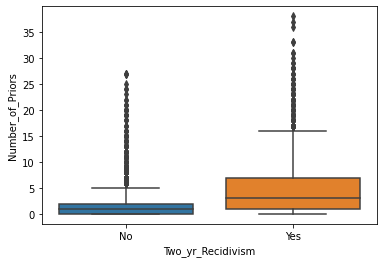

In [18]:
sns.boxplot(
    data=df.assign(Two_yr_Recidivism=lambda x: x['Two_yr_Recidivism'].map({0:'No', 1: 'Yes'})),
    y='Number_of_Priors',
    x='Two_yr_Recidivism'
)

- `Age_Below_TwentyFive`
- `African_American`
- `Hispanic`
- `Asian`
- `Native_American`
- `Female`
- `Misdemeanor`

In [19]:
df.groupby(['Two_yr_Recidivism', 'Age_Below_TwentyFive']).size()

Two_yr_Recidivism  Age_Below_TwentyFive
0                  0                       2770
                   1                        593
1                  0                       2055
                   1                        754
dtype: int64

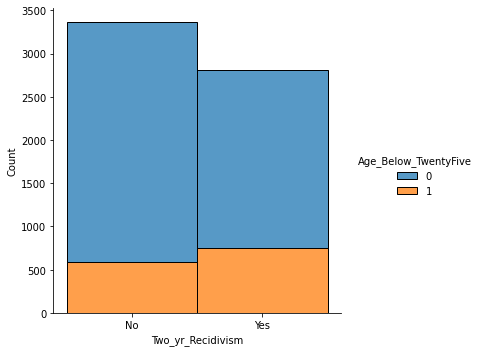

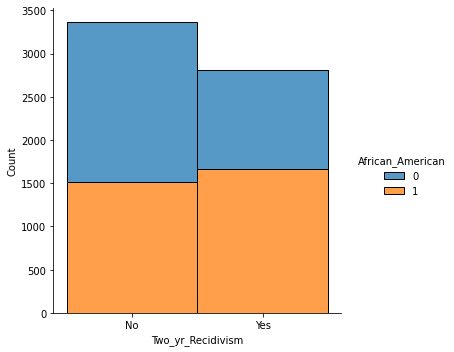

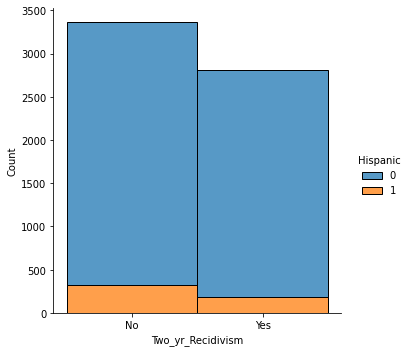

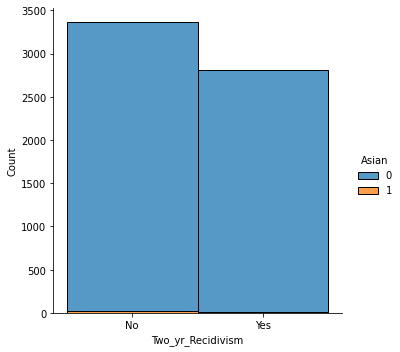

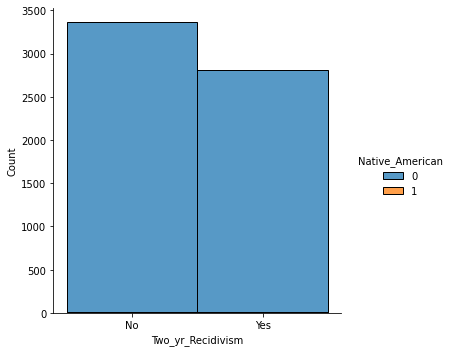

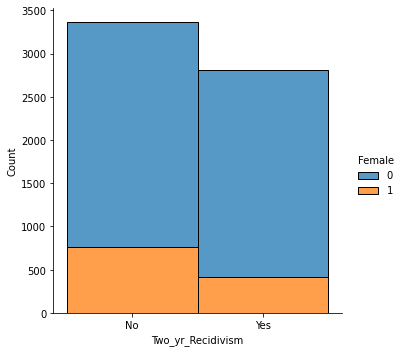

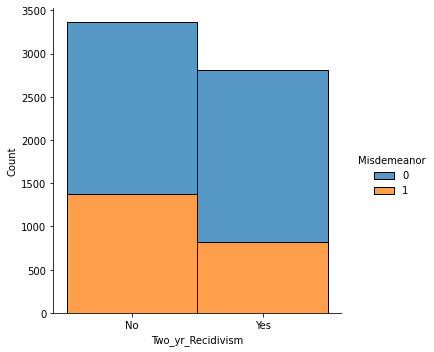

In [20]:
for col in [
    'Age_Below_TwentyFive',
    'African_American',
    'Hispanic',
    'Asian',
    'Native_American',
    'Female',
    'Misdemeanor',
]:
    sns.displot(
        data=df.assign(Two_yr_Recidivism=lambda x: x['Two_yr_Recidivism'].map({0:'No', 1: 'Yes'})), 
        x='Two_yr_Recidivism', 
        hue=col, 
        multiple='stack'
    )

### Correlation

<AxesSubplot: >

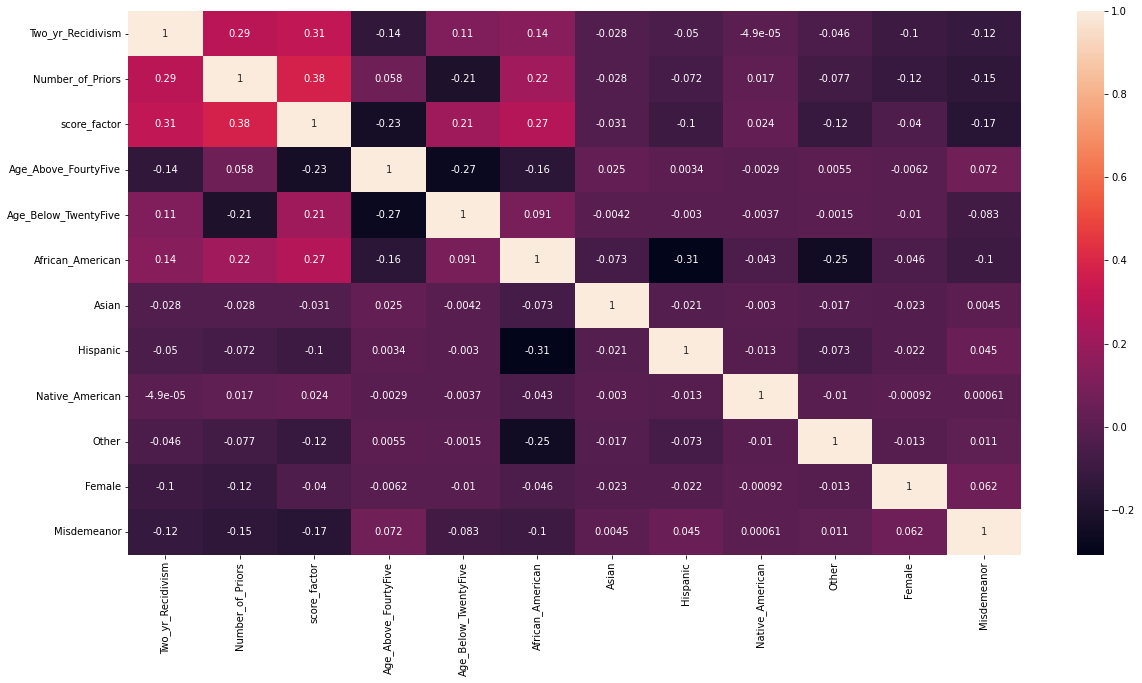

In [21]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True)

## Preprocessing

In [22]:
def assign_category(num_priors):
    if num_priors == 0:
        category = 'A'
    elif 1 <= num_priors <= 3:
        category = 'B'
    elif 4 <= num_priors <= 10:
        category = 'C'
    else:
        category = 'D'
    return category

In [23]:
processed_df = (
    df.assign(
        # Column for White race
        White=pd.Series(
            np
            .vectorize(check_if_race_is_white)
            (df['African_American'], 
             df['Asian'], 
             df['Hispanic'], 
             df['Native_American'], 
             df['Other'])
        )
        .fillna(0),
        # Column for category based on number of priors
        Category=np.vectorize(assign_category)(df['Number_of_Priors'])
    )
)

In [24]:
processed_df

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,White,Category
0,0,0,0,1,0,0,0,0,0,1,0,0,0,A
1,1,0,0,0,0,1,0,0,0,0,0,0,0,A
2,1,4,0,0,1,1,0,0,0,0,0,0,0,C
3,0,0,0,0,0,0,0,0,0,1,0,1,0,A
4,1,14,1,0,0,0,0,0,0,0,0,0,1,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,0,0,1,0,1,1,0,0,0,0,0,0,0,A
6168,0,0,0,0,1,1,0,0,0,0,0,0,0,A
6169,0,0,0,1,0,0,0,0,0,1,0,0,0,A
6170,0,3,0,0,0,1,0,0,0,0,1,1,0,B


## Modelling for `Two_yr_Recidivism`


Accuracy Score = 0.6587473002159827
Precision Score = 0.6481223922114048
Recall Score = 0.5514792899408284



,coefficient
Number_of_Priors,0.717177
Age_Below_TwentyFive,0.400476
African_American,0.080730
Native_American,-0.031729
Asian,-0.040205
Hispanic,-0.053255
Misdemeanor,-0.098310
Female,-0.105367


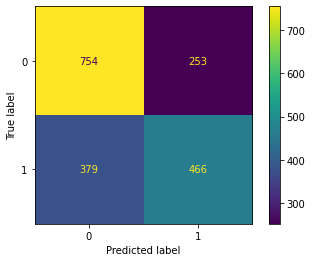

In [61]:
# Splitting X and y
X_1 = processed_df[[
    'Number_of_Priors', 'Age_Below_TwentyFive', 'African_American', 
    'Hispanic', 'Asian', 'Native_American', 'Female', 'Misdemeanor'
]]
y_1 = processed_df['Two_yr_Recidivism']

# Train-test-split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=101)

# Scaling
scaler = StandardScaler()
scaled_X_train_1 = scaler.fit_transform(X_train_1)
scaled_X_test_1 = scaler.transform(X_test_1)

# Fit model
model_1 = LogisticRegression()
model_1.fit(scaled_X_train_1, y_train_1)

# Create predictions
preds_1 = model_1.predict(scaled_X_test_1)

# Evaluate classification metrics
print(f"""
Accuracy Score = {accuracy_score(y_test_1, preds_1)}
Precision Score = {precision_score(y_test_1, preds_1)}
Recall Score = {recall_score(y_test_1, preds_1)}
""")
plot_confusion_matrix(model_1, scaled_X_test_1, y_test_1)

# Evaluate model coefficients
model_1_coefficients = (
    pd.DataFrame(
        columns=['coefficient'],
        index=X_1.columns,
        data=model_1.coef_.flatten()
    )
    .sort_values(by='coefficient', ascending=False)
)
model_1_coefficients

## Modelling for `score_factor`


Accuracy Score = 0.7516198704103672
Precision Score = 0.7398692810457517
Recall Score = 0.6844014510278114



,coefficient
Number_of_Priors,1.309894
Age_Below_TwentyFive,0.666145
African_American,0.351071
Female,0.097365
Native_American,0.014392
Asian,-0.015877
Hispanic,-0.041463
Misdemeanor,-0.159651


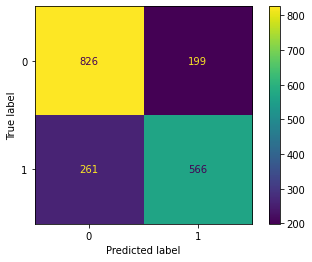

In [63]:
# Splitting X and y
X_2 = processed_df[[
    'Number_of_Priors', 'Age_Below_TwentyFive', 'African_American', 
    'Hispanic', 'Asian', 'Native_American', 'Female', 'Misdemeanor'
]]
y_2 = processed_df['score_factor']

# Train-test-split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=101)

# Scaling
scaler = StandardScaler()
scaled_X_train_2 = scaler.fit_transform(X_train_2)
scaled_X_test_2 = scaler.transform(X_test_2)

# Fit model
model_2 = LogisticRegression()
model_2.fit(scaled_X_train_2, y_train_2)

# Create predictions
preds_2 = model_2.predict(scaled_X_test_2)

# Evaluate classification metrics
print(f"""
Accuracy Score = {accuracy_score(y_test_2, preds_2)}
Precision Score = {precision_score(y_test_2, preds_2)}
Recall Score = {recall_score(y_test_2, preds_2)}
""")
plot_confusion_matrix(model_2, scaled_X_test_2, y_test_2)

# Evaluate model coefficients
model_2_coefficients = (
    pd.DataFrame(
        columns=['coefficient'],
        index=X_2.columns,
        data=model_2.coef_.flatten()
    )
    .sort_values(by='coefficient', ascending=False)
)
model_2_coefficients